### Installing Detectron2

In [1]:
# !python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

### Check if data is correctly loaded

In [2]:
# from detectron_dataset_skip_masks import GlaucomaDataset3
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from pycocotools import mask as coco_mask
# import numpy as np



# # Instantiate your dataset class
# # Replace root_dirs and max_images with appropriate values
# dataset = GlaucomaDataset3(["G1020-Safi50"], 100)

# # Randomly pick some indices
# indices_to_visualize = [1,2,3]  # Replace these with indices you want to visualize

# # Loop through and visualize
# for idx in indices_to_visualize:
#     data = dataset[idx]
#     image = plt.imread(data["file_name"])
#     annotations = data["annotations"]

#     fig, ax = plt.subplots(1, 3, figsize=(7, 5))

#     # Original Image
#     ax[0].imshow(image)
#     ax[0].set_title("Original Image")


#     for i, anno in enumerate(annotations):
#         # Masks
#         mask = coco_mask.decode(anno["segmentation"])
#         ax[i+1].imshow(mask)
#         ax[i+1].set_title("Mask for {}".format("Optic Disc" if anno["category_id"] == 0 else "Optic Cup"))

#         # Bounding Boxes
#         bbox = anno["bbox"]
#         rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
#         ax[i+1].add_patch(rect)

#     plt.show()


In [1]:
import torchvision
import os
import json
import csv
import random
# import gdown
import pickle


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# import cv2
# from dataset import GlaucomaDataset

# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Import Detectron2 utilities
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Import other utilities
# from detectron_dataset import GlaucomaDataset2  
from detectron_dataset_skip_masks import GlaucomaDataset3  # Your existing dataset code

from sklearn.model_selection import train_test_split


### HyperParams

In [2]:
# from detectron_dataset import GlaucomaDataset2
from detectron_dataset_skip_masks import GlaucomaDataset3

root_dirs = [""]
val_dir = [ ""]
lr = 1e-4
batch_size = 1
num_workers = 4
# total_epoch = 4080
total_epoch = 5
max_images=None
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Registering Dataset 

In [3]:
from detectron_dataset_skip_masks import GlaucomaDataset3

# Register your dataset to Detectron2's DatasetCatalog
def register_glaucoma_dataset():
    # train_set = GlaucomaDataset2(root_dirs, split='train', max_images=max_images)
    train_set = GlaucomaDataset3(root_dirs, max_images=max_images)
    train_data, test_data = train_test_split(train_set, random_state=42, test_size=0.2)
    
    # Register datasets to Detectron2
    DatasetCatalog.register("glaucoma_train", lambda: train_data)
    DatasetCatalog.register("glaucoma_test", lambda: test_data)

    MetadataCatalog.get("glaucoma_train").set(thing_classes=["Optic Disc", "Optic Cup"])
    MetadataCatalog.get("glaucoma_test").set(thing_classes=["Optic Disc", "Optic Cup"])

register_glaucoma_dataset()

Succesfully loaded train dataset.                                                  
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...


/Users/huzaifa/Documents/GitHub/FYP/Detectron/detectron_dataset_skip_masks.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  boxes = torch.tensor([od_bbox, oc_bbox])


Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty bbox...
Empty mask, returning empty 

### Detectron2 Config

In [4]:
# Detectron2 model configuration and training
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("glaucoma_train",)
cfg.DATASETS.TEST = ("glaucoma_test",)
cfg.INPUT.MASK_FORMAT = "bitmask"

# image size for training
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MAX_SIZE_TRAIN = 1024

# image size for testing
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1024


cfg.DATALOADER.NUM_WORKERS = num_workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = lr
cfg.SOLVER.MAX_ITER = total_epoch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # Optic Disc, Optic Cup



### Checking if Data is being loaded correctly

Number of samples in training set:  816


/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tens

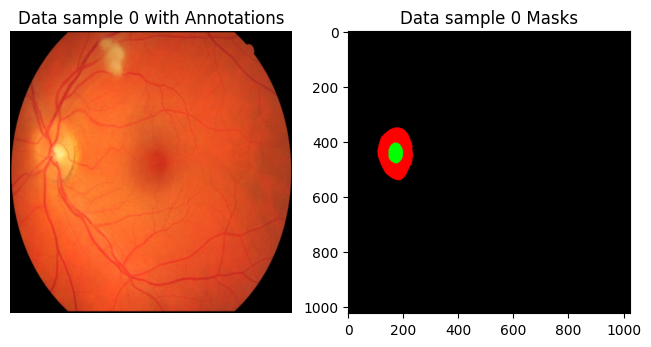

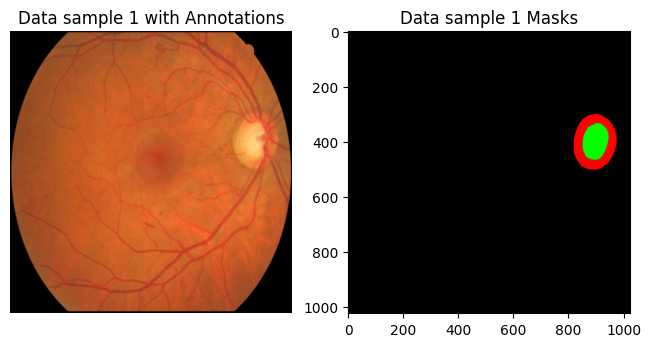

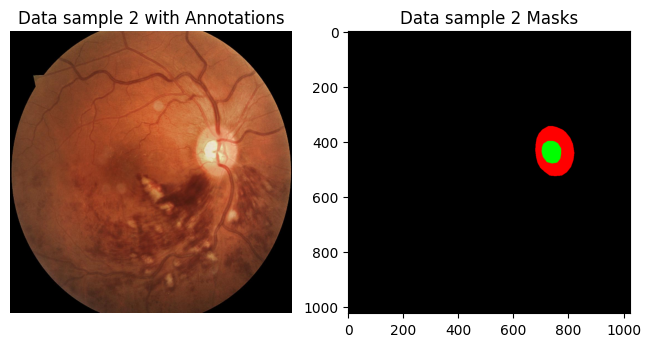

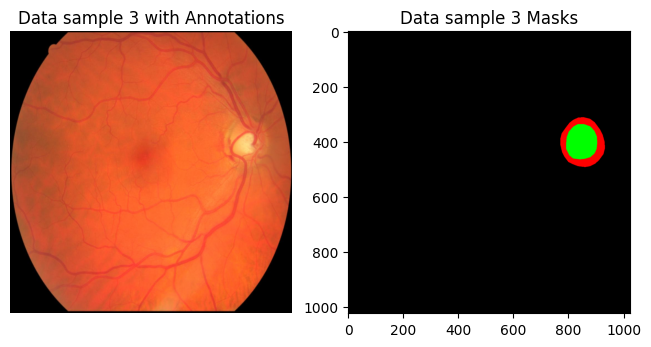

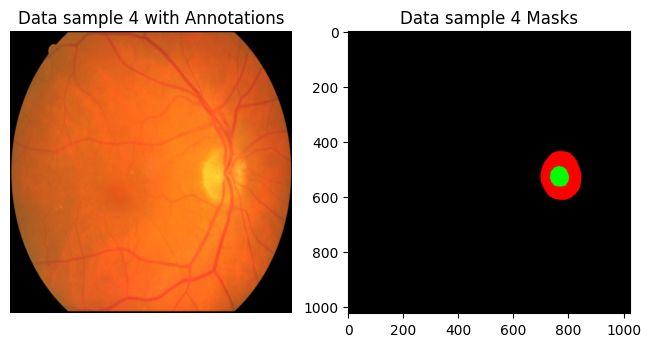

In [5]:
from detectron2.data import build_detection_train_loader
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Create a data loader
train_data_loader = build_detection_train_loader(cfg)
train_metadata = MetadataCatalog.get("glaucoma_train")

# Assuming "glaucoma_train" is the name of your training dataset
train_dataset = DatasetCatalog.get("glaucoma_train")
print("Number of samples in training set: ", len(train_dataset))

# Loop to visualize first 5 samples
for i, batch in enumerate(train_data_loader):
    if i >= 5:
        break
    
    # Each 'batch' is a list of dicts. We'll use the first (and only) dict in our case
    data_sample = batch[0]
    
    # Retrieve image from data_sample
    img = np.array(data_sample["image"].permute(1, 2, 0).cpu().detach().numpy(), dtype=np.uint8)
    
    # Annotations
    annotations = data_sample["instances"].to("cpu")
    
    # Masks from annotations
    masks = annotations.gt_masks.tensor.numpy()
    labels = annotations.gt_classes.cpu().numpy()
    
    # Visualize
    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)
    vis_output = visualizer.draw_instance_predictions(annotations)

    # Create a figure with sub-plots
    fig, axes = plt.subplots(1, 2, figsize=(8, 6))

    # Show the image with annotations
    axes[0].imshow(vis_output.get_image()[:, :, ::-1])
    axes[0].set_title(f"Data sample {i} with Annotations")
    axes[0].axis("off")

    # Create an empty mask
    colored_masks = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)

    for j in range(masks.shape[0]):
        label = labels[j]
        mask = masks[j]
        if label == 0:  # Assuming label 0 is for OD
            colored_masks[mask == 1] = [255, 0, 0]  # Red for OD
        elif label == 1:  # Assuming label 1 is for OC
            colored_masks[mask == 1] = [0, 255, 0]  # Green for OC

    # Show the masks
    axes[1].imshow(colored_masks)
    axes[1].set_title(f"Data sample {i} Masks")

    # Show the figure
    plt.show()


### Trainer setup


In [6]:
# Trainer setup
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)



[10/31 14:36:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

### Start training


In [7]:
trainer.train()


[10/31 14:36:04 d2.engine.train_loop]: Starting training from iteration 0


/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tens

[10/31 14:36:21 d2.utils.events]:  eta: 0:00:00  iter: 4  total_loss: 2.053  loss_cls: 1.037  loss_box_reg: 0.03801  loss_mask: 0.6939  loss_rpn_cls: 0.2342  loss_rpn_loc: 0.01978    time: 3.0543  last_time: 3.0449  data_time: 0.2641  last_data_time: 0.0002   lr: 8.002e-05  
[10/31 14:36:25 d2.engine.hooks]: Overall training speed: 3 iterations in 0:00:09 (3.0543 s / it)
[10/31 14:36:25 d2.engine.hooks]: Total training time: 0:00:13 (0:00:04 on hooks)
[10/31 14:36:25 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
| Optic Disc | 204          | Optic Cup  | 158          |
|            |              |            |              |
|   total    | 362          |            |              |
[10/31 14:36:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='c

### Testing Predictions

In [8]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# Evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Assuming cfg is your trained model's config
# Load the model weights
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.MASK_ON = True

# Create a predictor instance
predictor = DefaultPredictor(cfg)

# Get test data loader

# Create COCO Evaluator
evaluator = COCOEvaluator("glaucoma_test", output_dir="./output")


# Build the test loader
test_loader = build_detection_test_loader(cfg, "glaucoma_test")
test_metadata = MetadataCatalog.get("glaucoma_test")

print(test_loader.dataset[0].keys())

# Run Evaluation
eval_results = inference_on_dataset(predictor.model, test_loader, evaluator)
print(eval_results)
print("Average Precision (AP):", eval_results["bbox"]["AP"])
print("Average Precision at IoU 0.50 (AP50):", eval_results["bbox"]["AP50"])
print("Average Precision at IoU 0.75 (AP75):", eval_results["bbox"]["AP75"])
print("Medium object AP (APm):", eval_results["bbox"]["APm"])
print("Large object AP (APl):", eval_results["bbox"]["APl"])




[10/31 14:36:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[10/31 14:36:26 d2.evaluation.coco_evaluation]: Trying to convert 'glaucoma_test' to COCO format ...
WARNING [10/31 14:36:26 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/glaucoma_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[10/31 14:36:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=1024, sample_style='choice')]
[10/31 14:36:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/31 14:36:26 d2.data.common]: Serializing 204 elements to byte tensors and concatenating them all ...
[10/31 14:36:26 d2.data.common]: Serialized dataset takes 0.24 MiB
dict_keys(['file_name', 'image_id', 'height', 'width', 'image'])
[10/31 14:36:26 d2.evaluation.eval

### Calculating Custom IOU's 

In [11]:
# Assuming you have already registered the dataset
from detectron2.data import DatasetCatalog

# Get ground truth dataset
gt_dataset = DatasetCatalog.get("glaucoma_test")

print(gt_dataset[0]['annotations'][0].keys())




dict_keys(['bbox', 'bbox_mode', 'category_id', 'segmentation'])


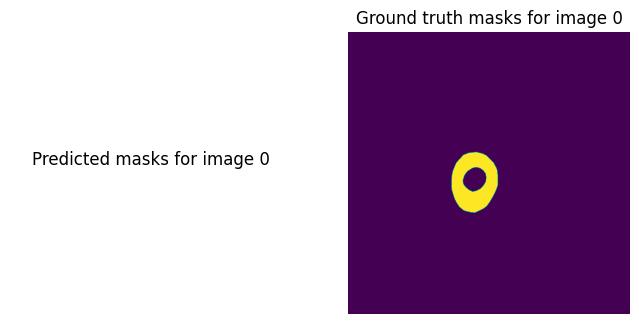

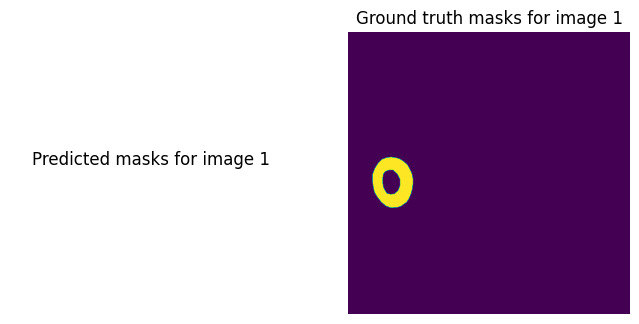

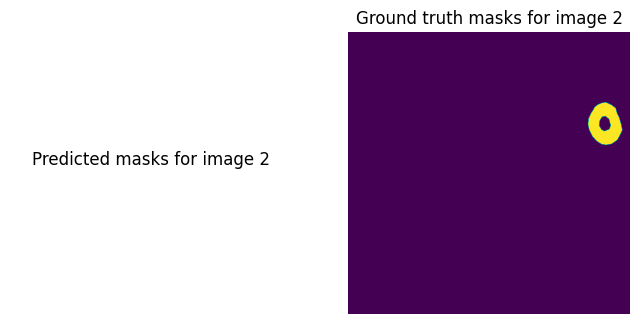

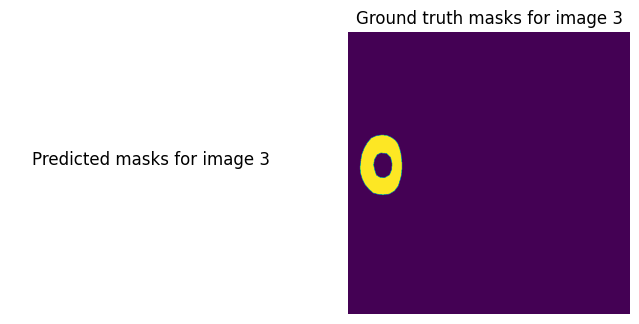

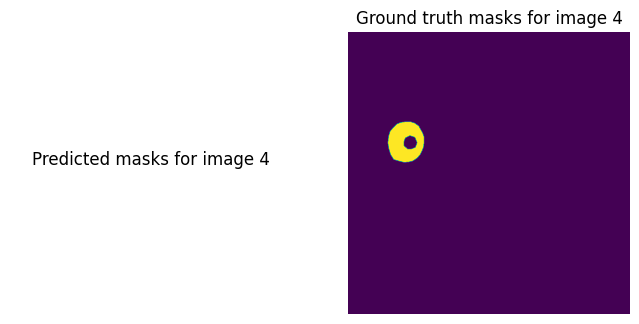

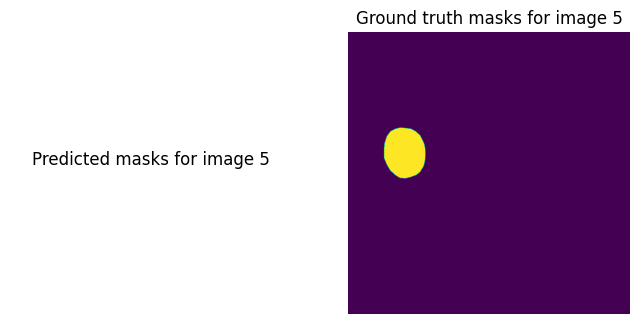

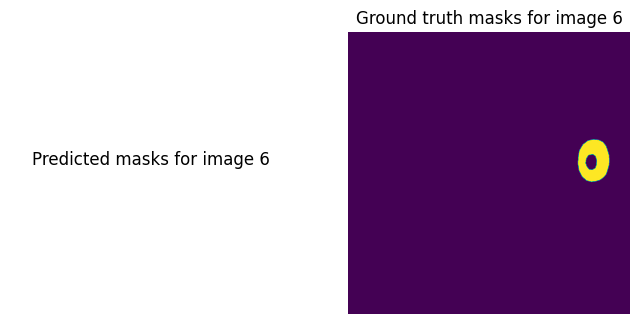

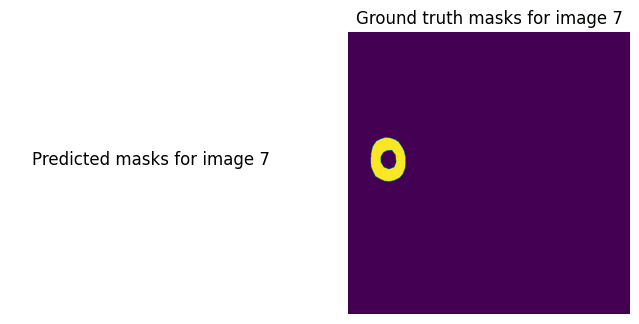

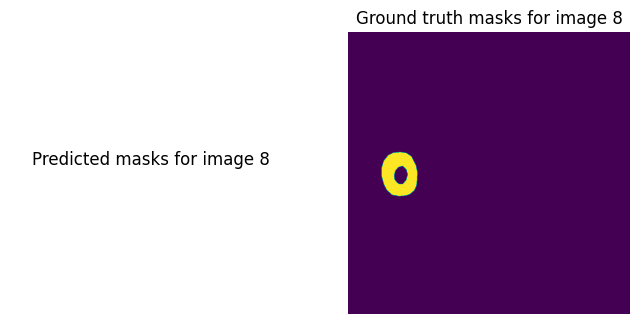

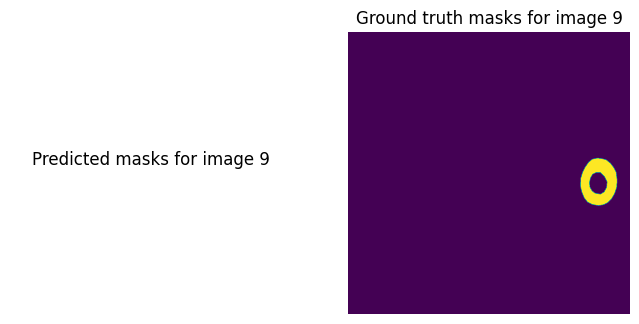

KeyboardInterrupt: 

In [12]:
from detectron2.structures import Boxes, BoxMode
from pycocotools import mask as mask_utils
from sklearn.metrics import jaccard_score
import numpy as np
import cv2
import matplotlib.pyplot as plt

iou_thresholds = np.arange(0.4, 0.7, 0.1)

for idx, data in enumerate(gt_dataset):
    # Get predicted masks
    outputs = predictor(cv2.imread(data["file_name"]))
    highest_score_idx = outputs["instances"].scores.argmax()
    highest_score_mask = outputs["instances"].pred_masks[highest_score_idx].cpu().numpy()
    
    # Get ground truth masks
    gt_masks_rle = data['annotations'][0]['segmentation']
    gt_masks = mask_utils.decode(gt_masks_rle)
    
    # Reshape for jaccard_score function
    highest_score_mask = highest_score_mask.reshape(1, -1)
    gt_masks = gt_masks.reshape(gt_masks.shape[0], -1)
    
    # Visualize masks 
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(highest_score_mask.reshape((highest_score_mask.shape[-2], highest_score_mask.shape[-1])))
    ax[0].set_title(f"Predicted masks for image {idx}")
    ax[0].axis("off")
    ax[1].imshow(gt_masks)
    ax[1].set_title(f"Ground truth masks for image {idx}")
    ax[1].axis("off")
    plt.show()
    
    # # Compute IOUs for various thresholds
    # for threshold in iou_thresholds:
    #     bin_predicted_mask = highest_score_mask >= threshold
    #     iou = jaccard_score(gt_masks, bin_predicted_mask, average='samples')
    #     print(f"IOU at threshold {threshold} for image {idx}: {iou}")


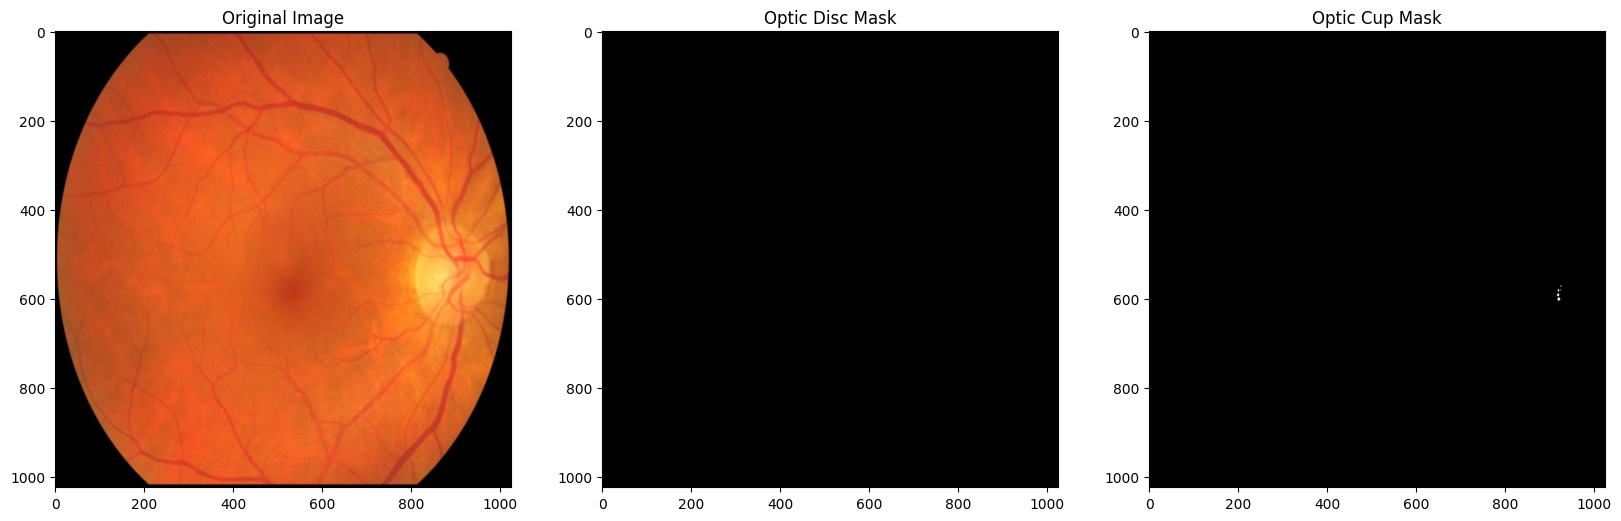

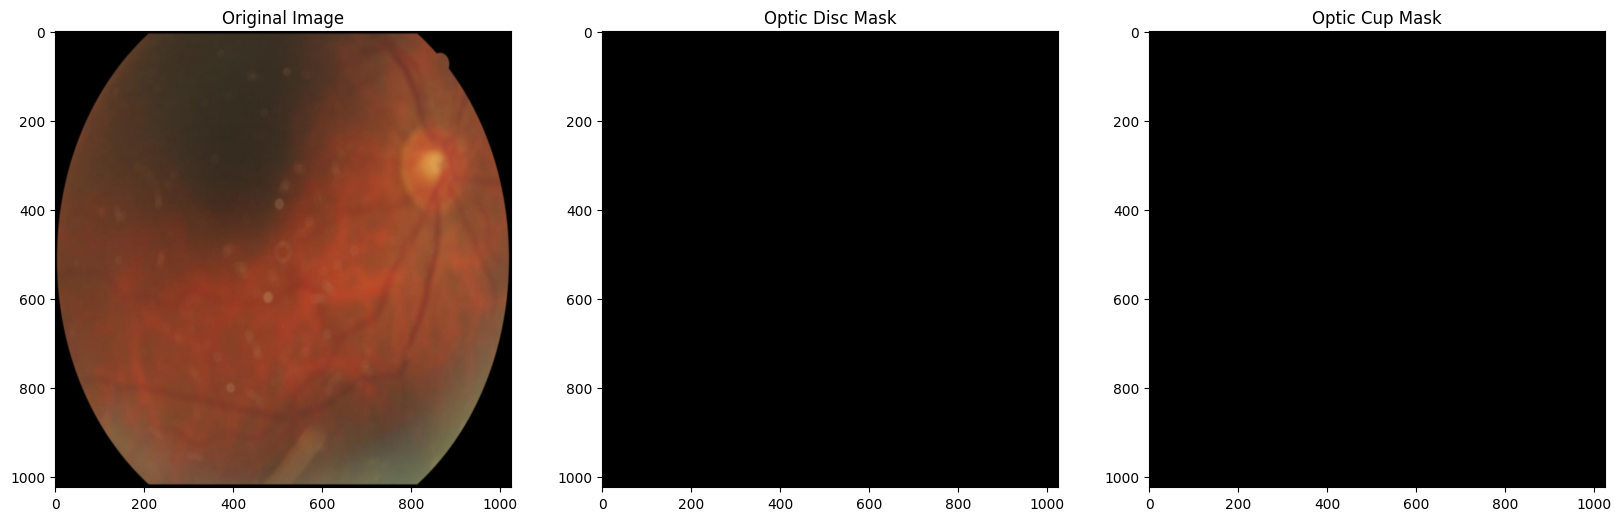

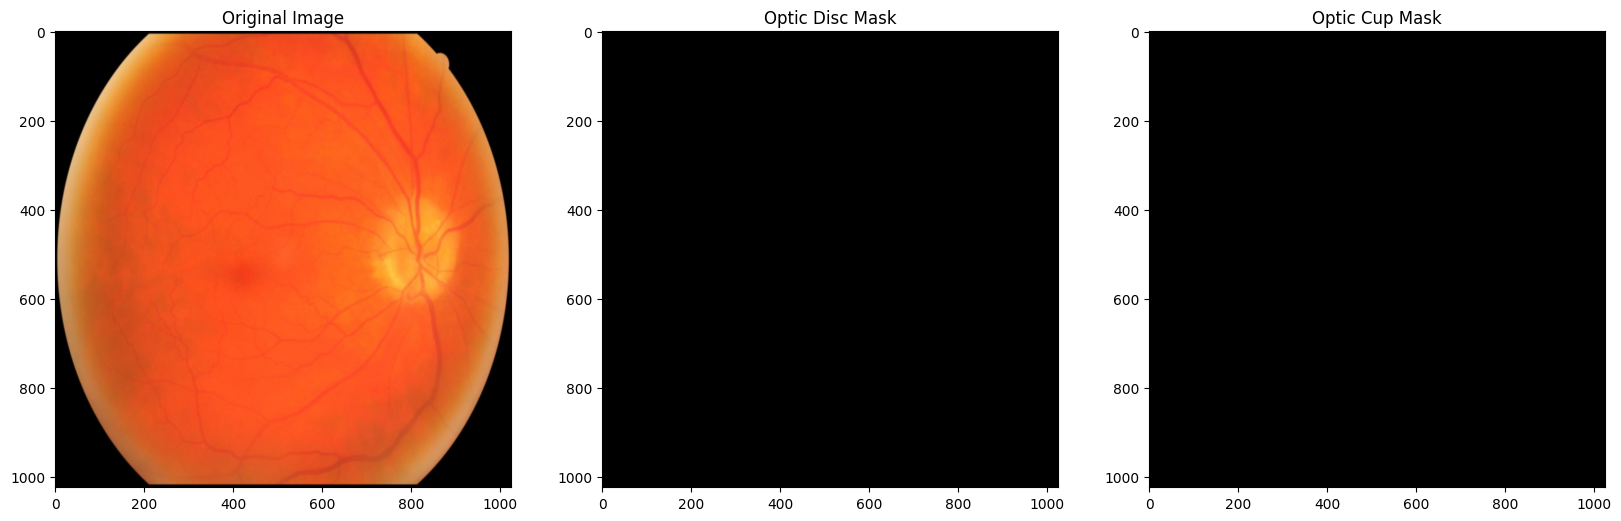

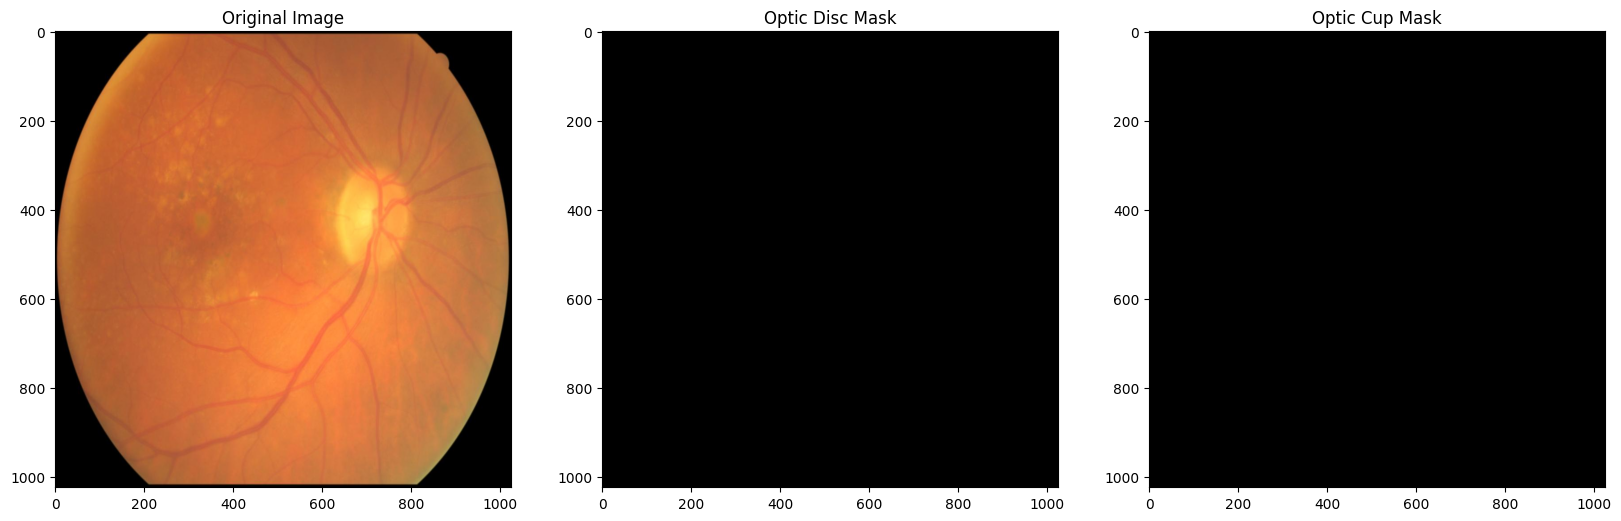

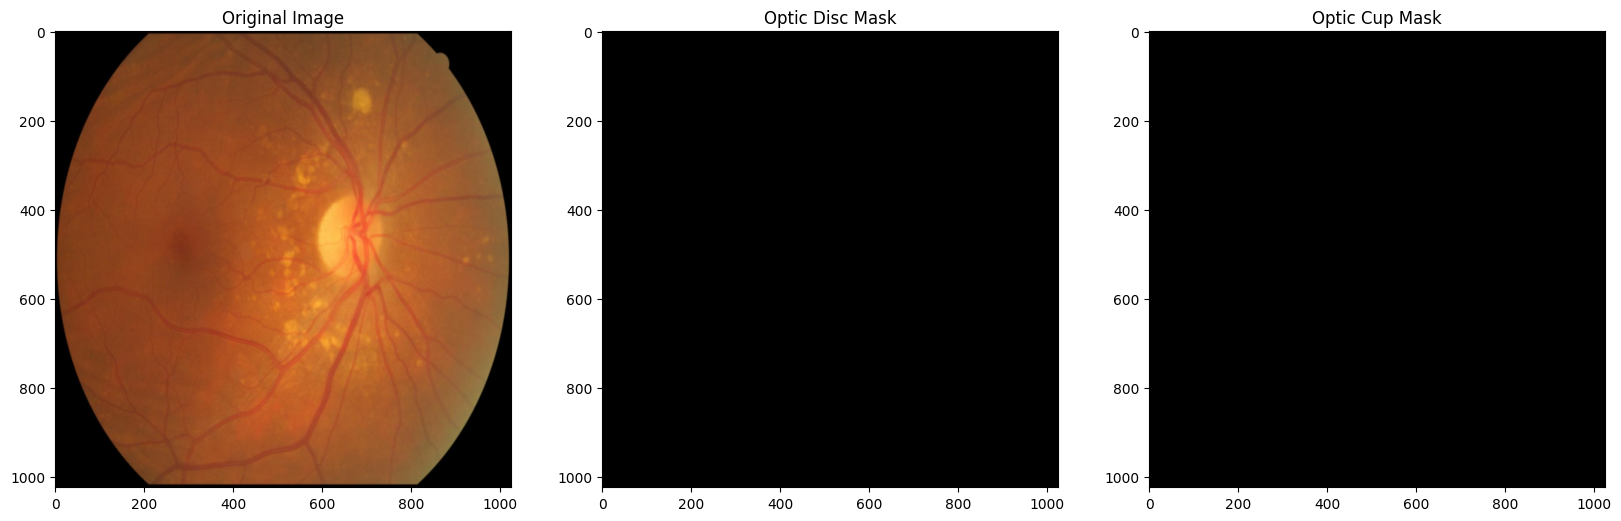

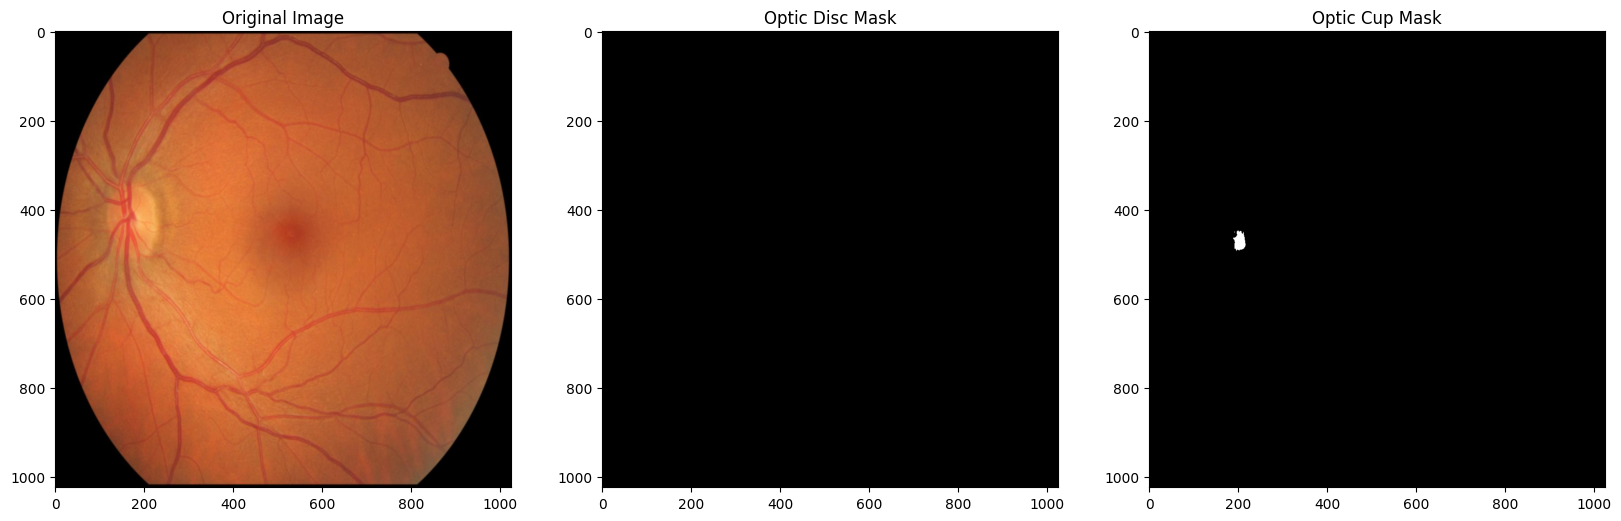

In [10]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# Assuming necessary imports and configurations are already done
# ...

# Get the total number of samples
total_samples = len(test_loader)

# Shuffle and pick 5 random indices
random_indices = random.sample(range(total_samples), 6)

for i, batch in enumerate(test_loader):
    if i in random_indices:
        img_path = batch[0]["file_name"]
        img = cv2.imread(img_path)

        # Make prediction
        outputs = predictor(img)
        # print(outputs['instances'])

        # Sort by confidence scores
        sorted_indices = outputs["instances"].scores.argsort(descending=True)

        # Get sorted masks and classes
        pred_masks = outputs["instances"].pred_masks[sorted_indices].cpu().numpy()
        pred_classes = outputs["instances"].pred_classes[sorted_indices].cpu().numpy()

        # Get the highest confidence masks for optic disc and optic cup
        optic_disc_mask = pred_masks[pred_classes == 0][0] if np.any(pred_classes == 0) else None
        optic_cup_mask = pred_masks[pred_classes == 1][0] if np.any(pred_classes == 1) else None
        
        # Visualization
        v = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=1.0)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Create a subplot of 1 row and 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))

        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')

        if optic_disc_mask is not None:
            axes[1].imshow(optic_disc_mask, cmap='gray')
            axes[1].set_title('Optic Disc Mask')
        else:
            axes[1].set_title('Optic Disc Mask (Not Found)')

        if optic_cup_mask is not None:
            axes[2].imshow(optic_cup_mask, cmap='gray')
            axes[2].set_title('Optic Cup Mask')
        else:
            axes[2].set_title('Optic Cup Mask (Not Found)')

        plt.show()
